# Interactive Analysis Notebook

In [1]:
# Import packages and dependencies
import time
import matplotlib
from matplotlib import pyplot as plt
import os
from pathlib import Path
from pipeline import pipeline
from analysis import *
import figure
from subject_analysis import Dataset, Cohort, Subject
import compute_ld_centering

In [2]:
RESEARCH_DIR = Path("/Users/anantajit/Documents/UCSF")
COHORT = \
    "LD/FullDataset"
SOURCE_FILE = \
    "raw_dataset.mat"
DEMOGRAPHICS_FILE = \
    "demographics.csv"
SOURCE_STRUCT = \
    "LD_Patients"

INPUT_PATH = RESEARCH_DIR / "datasets" / COHORT
DEMOGRAPHICS_PATH = INPUT_PATH / DEMOGRAPHICS_FILE
OUTPUT_PATH = RESEARCH_DIR / "results" / COHORT
CACHE_PATH = RESEARCH_DIR / "results" / COHORT / "cache"

FORCE_ANALYSIS = False

DPI = 300
plot_settings = {
    "plot_order": ["Controls", "LD Patients"],
    "colormap": {
        "LOWER": "#1f77b4",
        "CENTRAL": "#ff7f0e",
        "UPPER": "#2ca02c"
    },

    "error-color": "black",
    "line-width": 1.5,
    "error-cap-size": 10,
    "error-line-style": '',
    "font_size": 14,
    "font_family": "Times New Roman",

    "motion_lw": 2.0,
    "motion_alpha": 0.75,

    "annotation_padding": 2
}

trimming_pipeline = [
        trim_by_subject_trial_count,  # remove subjects with <25 trials
        trim_by_group_initial_pitch_distribution,  # remove trials which have initial pitch deviation >2std from mean
        (trim_by_subject_name,
         dict(exclude=[("LD Patients", "20170516"), ("LD Patients", "20170307")])
         ),
        rename_subjects_by_group  # is this strictly necessary?
    ]

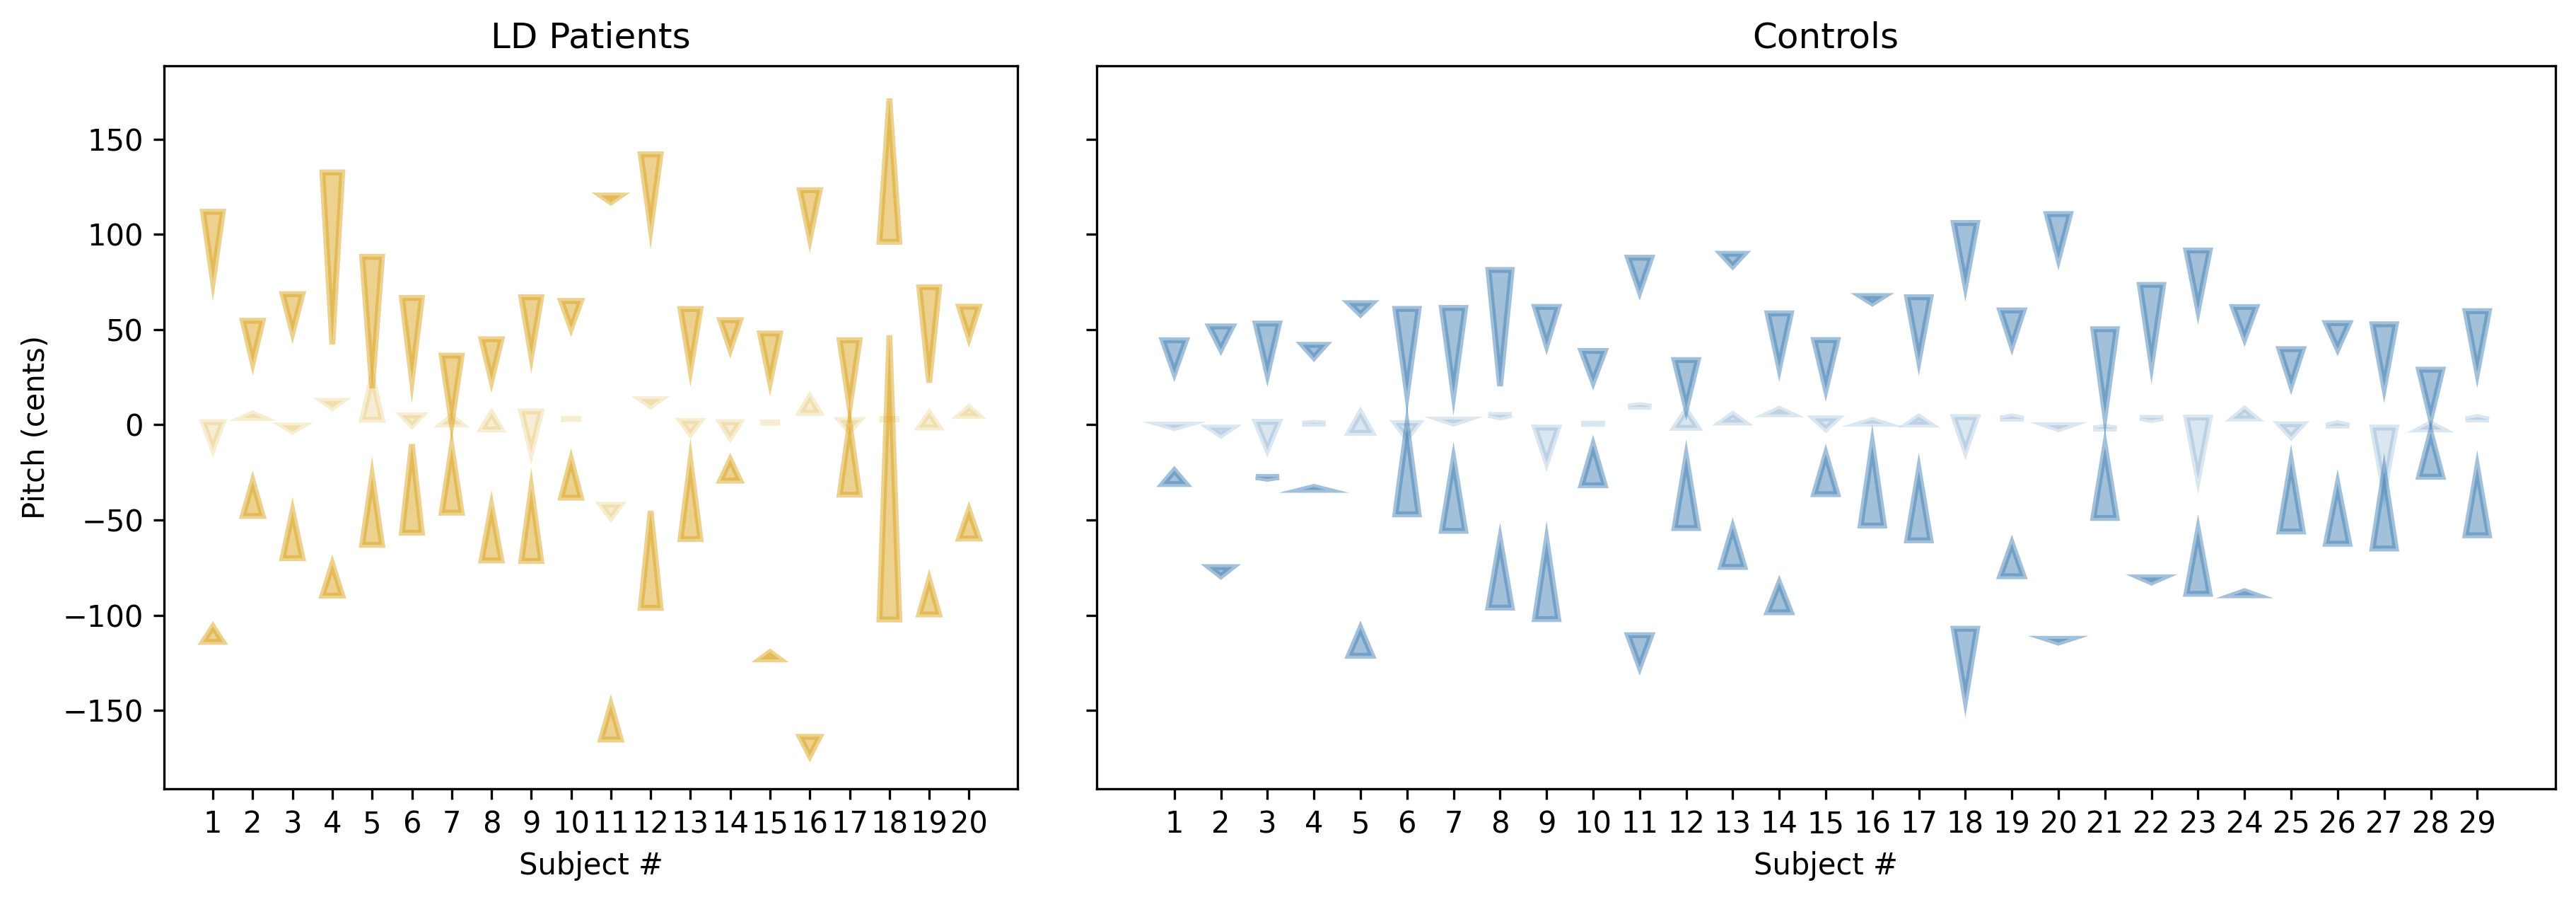

In [3]:
ld = Dataset(str(INPUT_PATH / SOURCE_FILE), SOURCE_STRUCT)
demographics = pd.read_csv(DEMOGRAPHICS_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH) / "centering_data.csv").is_file():
    compute_ld_centering.gen_centering_csv(dataset=ld, OUTPUT_PATH=OUTPUT_PATH, CACHE_PATH=CACHE_PATH)

if FORCE_ANALYSIS or not (Path(CACHE_PATH / "trimmed_dataset.csv").is_file()
                          and Path(CACHE_PATH / "peripheral_dataset.csv").is_file()):
    compute_ld_centering.gen_centering_analysis(demographics=demographics, CACHE_PATH=CACHE_PATH)

# TODO: move plotting code into more accessible cells here
# compute_ld_centering.gen_group_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)
# compute_ld_centering.gen_subject_figures(dataset=ld, CACHE_PATH=CACHE_PATH, OUTPUT_PATH=OUTPUT_PATH, plot_settings=plot_settings, DPI=DPI)


ld = pd.read_csv(CACHE_PATH / "trimmed_dataset.csv")

# for each group name, store the proportion of the rows which correspond to that group
group_proportions = ld["Group Name"].value_counts(normalize=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), dpi=DPI, sharey=True, 
                         gridspec_kw={"width_ratios": 1 - group_proportions})
fig.tight_layout()
figure.group_arrow_distribution(
    ld,
    fig,
    {
        "colormap": {
            "LD Patients": "goldenrod",
            "Controls": "steelblue"
        }
    },
    ("LD Patients", "Controls"),
)

plt.savefig(OUTPUT_PATH / "group_arrow_distribution.png", dpi=DPI)